In [1]:
## Importing Libraries

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import itertools
import torch
import random
import time
import copy
import matplotlib.pyplot as plt

SEED = 42
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower
fix_random(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device = torch.device('cpu')

print('Using device:', device)

Using device: cpu


In [2]:
class TabTransformer(torch.nn.Module):
    def __init__(self, num_features, num_classes, dim_embedding=8, num_heads=2, num_layers=2):
        super(TabTransformer, self).__init__()
        self.embedding = torch.nn.Linear(num_features, dim_embedding)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
        self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = torch.nn.Linear(dim_embedding, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Adding a sequence length dimension
        x = self.transformer(x)
        x = torch.mean(x, dim=1)  # Pooling
        x = self.classifier(x)
        return x

In [3]:
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, scheduler, patience):
    n_iter = 0

    best_model = None
    best_val_loss = float('inf')
    epochs_since_last_improvement = 0

    start = time.time()

    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()

        start_epoch = time.time()

        loss_train = 0
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets.long())
            loss.backward()
            optimizer.step()
            n_iter += 1
            loss_train += loss.item()

        scheduler.step()
        loss_train /= len(data_loader)

        # Compute Val Loss
        val_loss,_,_ = test_model(model, criterion, val_loader)

        loss_history.append(loss_train)
        val_loss_history.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs_since_last_improvement = 0
        elif epochs_since_last_improvement >= patience:
            break
        else:
            epochs_since_last_improvement += 1

        print('Epoch [{}/{}] - {:.2f} seconds - train_loss: {:.6f} - val_loss: {:.6f} - patience: {}'.format(epoch+1,
              epochs, time.time() - start_epoch, loss_train, val_loss, epochs_since_last_improvement), end='\r')

    print('\nTraining ended after {:.2f} seconds - Best val_loss: {:.6f}'.format(time.time() - start, best_val_loss))

    return best_model, loss_history, val_loss_history


def test_model(model, criterion, loader):
    model.eval()
    y_pred = torch.tensor([],requires_grad=True).to(device)
    y_true = torch.tensor([],requires_grad=True).to(device)

    total_loss = 0.0
    
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        preds = model(data)
        loss = criterion(preds, targets.long())
        total_loss += loss.item()
        y_pred = torch.cat((y_pred, preds.squeeze()))
        y_true = torch.cat((y_true, targets.detach()))

    avg_loss = total_loss / len(loader)
    return avg_loss, y_pred.squeeze(), y_true.squeeze()

In [4]:
## Load Data

FILENAME = "train_dataset.csv"

df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
df1 = df1.dropna()
y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# X = X.to_numpy()
y = y.to_numpy()


## Categorical Embedding

X_cat = X.select_dtypes(include=['object'])
X_num = X.select_dtypes(exclude=['object'])
oe = preprocessing.OrdinalEncoder()
oe.fit(X_cat)
X_cat = oe.transform(X_cat)
X = np.concatenate((X_cat, X_num), axis=1)
print(X.shape)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


## Train, Validation and Test Set

indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=SEED)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=SEED)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1

ps = PredefinedSplit(fold)
ps.get_n_splits()

y_test = y[test_idx]
y_train = y[train_idx]
y_val = y[val_idx]

X_test = X[test_idx,:]
X_train = X[train_idx,:]
X_val = X[val_idx,:]

## Preprocess and splitting

# Apply LDA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# X_train = lda.transform(X_train)
# X_val = lda.transform(X_val)
# X_test = lda.transform(X_test)


num_feature = X_train.shape[1]
num_classes = len(np.unique(y_train))

# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=y_val.shape[0], shuffle=False)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test.shape[0], shuffle=False)

(616983, 44)


In [5]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=y_val.shape[0], shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test.shape[0], shuffle=False)

In [6]:
nums_epochs = [1000]
batch_sizes = [16]
patience = [20]
dim_embedding = [16]
num_heads = [8]
num_layers = [2]
learning_rate = [0.001]
hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, dim_embedding, num_heads, num_layers, learning_rate))
n_comb = len(hyperparameters)
print (f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 1


In [7]:
## Class Weights

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights = torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device)
print(class_weights)

tensor([ 4.0695,  0.3381,  1.1325,  4.5437, 98.6295,  2.9864,  1.1967, 63.8257,
         0.2880,  0.9752])


In [8]:
# Initialize the model, loss, and optimizer
best_loss = float('inf')
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
current_iter = 0
for epochs, batch_size, patience_, dim_embedding_, num_heads_, num_layers_, lr in hyperparameters:

    print(f'Iteration {current_iter+1}/{n_comb} - Hyperparameters: epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}')
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, drop_last=True)

    model = TabTransformer(num_feature, num_classes).to(torch.device('cpu'))
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    model, loss_history, val_loss_history = train_model(model, criterion, optimizer, epochs, train_loader, val_loader, device, scheduler, patience_)
    val_loss, y_pred, y_true = test_model(model, criterion, val_loader)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        best_hyperparameters = f"epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}"

    print(f'Hyperparameters: epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}')
    print(f'Validation Loss: {val_loss}')

    current_iter += 1

Iteration 1/1 - Hyperparameters: epochs=1000, batch_size=16, patience=20, dim_embedding=16, num_heads=8, num_layers=2, lr=0.001
Epoch [64/1000] - 122.00 seconds - train_loss: 0.041601 - val_loss: 0.083359 - patience: 20
Training ended after 7213.83 seconds - Best val_loss: 0.046221
Hyperparameters: epochs=1000, batch_size=16, patience=20, dim_embedding=16, num_heads=8, num_layers=2, lr=0.001
Validation Loss: 0.046220630407333374


Best hyperparameters: epochs=1000, batch_size=16, patience=20, dim_embedding=16, num_heads=8, num_layers=2, lr=0.001
Test Loss: 0.03687356784939766
Test Accuracy: 0.9952996855651723


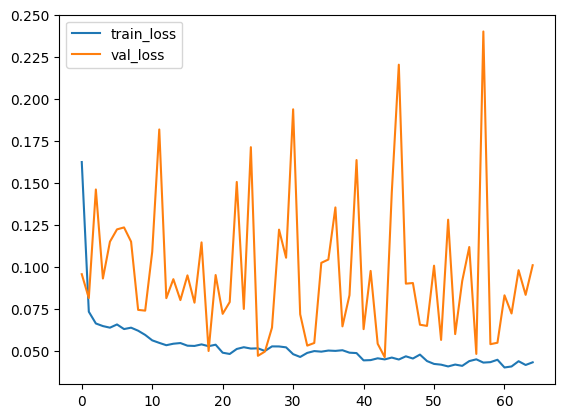

In [9]:
test_loss, y_pred, y_true = test_model(best_model, criterion, test_loader)
y_pred = torch.argmax(y_pred, dim=1)
print(f'Best hyperparameters: {best_hyperparameters}')
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {accuracy_score(y_true.detach().numpy(), y_pred.detach().numpy())}')
plt.plot(loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_test), y=y_test)

y_test = y_test.to_device('cpu')

print(classification_report(y_test, y_pred))
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Balanced accuracy: {accuracy_score(y_test, y_pred, sample_weight=(np.array([class_weights[i] for i in y_test])))}')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       758
           1       1.00      1.00      1.00      9124
           2       1.00      0.98      0.99      2724
           3       0.91      0.99      0.95       679
           4       0.83      0.97      0.90        31
           5       1.00      0.98      0.99      1033
           6       0.99      1.00      0.99      2578
           7       0.77      1.00      0.87        48
           8       1.00      1.00      1.00     10710
           9       1.00      0.99      0.99      3164

    accuracy                           1.00     30849
   macro avg       0.95      0.99      0.97     30849
weighted avg       1.00      1.00      1.00     30849

F1 Score: 0.9953699881150784
Balanced accuracy: 0.9894945724971667
